<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
!pip install Ta-Lib

In [ ]:
pip install Ta-Lib -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
pip install git+https://github.com/quantopian/pyfolio

In [ ]:
## install finrl library
!pip install wrds -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install swig -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git 


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
import torch
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
# matplotlib.use('Agg')
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
#from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_adjust import StockTradingEnv
from finrl.agents.stablebaselines3.models_add import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../mha-gru-drl")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

In [7]:
TRAIN_START_DATE = '2017-03-02'
TRAIN_END_DATE = '2020-02-27'
TRADE_START_DATE = '2020-02-28'
TRADE_END_DATE = '2023-12-01'

In [8]:
import tushare as ts
ts.set_token('df3c6a8e252ff736ca08a3364022e4340b68485bf9f9d3cea4c94f21')
pro = ts.pro_api()

In [9]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20121010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [17]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20160229' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['601318.SH' '600016.SH' '601166.SH' '600000.SH' '600036.SH' '601328.SH'
 '601288.SH' '600030.SH' '600519.SH' '600837.SH' '601169.SH' '601398.SH'
 '601766.SH' '600887.SH' '601668.SH' '601601.SH' '601988.SH' '600104.SH'
 '600048.SH' '601818.SH' '601989.SH' '600015.SH' '600028.SH' '600637.SH'
 '601688.SH' '601390.SH' '600999.SH' '600518.SH' '601006.SH' '601857.SH'
 '600050.SH' '601186.SH' '601628.SH' '601985.SH' '600795.SH' '600585.SH'
 '600893.SH' '601088.SH' '600010.SH' '601901.SH' '601211.SH' '601669.SH'
 '600111.SH' '601336.SH' '600109.SH' '600958.SH' '601998.SH' '601800.SH'
 '600018.SH' '600150.SH'] 50


In [18]:
#随机选择成分股中的k只股票
import random 
k = 50
selected_tics = random.sample(list(sort_SSEindex),k)
print(selected_tics)

['601328.SH', '600109.SH', '601998.SH', '600111.SH', '600050.SH', '601169.SH', '600887.SH', '600795.SH', '601336.SH', '601818.SH', '601390.SH', '601688.SH', '600016.SH', '601800.SH', '600958.SH', '601166.SH', '600015.SH', '600010.SH', '600104.SH', '600150.SH', '601985.SH', '600028.SH', '600030.SH', '601186.SH', '600999.SH', '600585.SH', '601601.SH', '600036.SH', '601288.SH', '601006.SH', '601901.SH', '601989.SH', '601857.SH', '601668.SH', '600048.SH', '601988.SH', '600518.SH', '601628.SH', '601318.SH', '600018.SH', '601398.SH', '600000.SH', '601669.SH', '601211.SH', '600637.SH', '601088.SH', '600837.SH', '600893.SH', '601766.SH', '600519.SH']


In [ ]:

selected_tics = ['600104.SH','600050.SH','600048.SH','600036.SH','600031.SH','600030.SH','600028.SH','600016.SH','600009.SH','600000.SH']


In [19]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date=TRAIN_START_DATE,end_date=TRADE_END_DATE)
    df_ts=pd.concat([df_ts,temp])
print(df_ts)

        ts_code trade_date    open    high     low   close  pre_close  change  \
0     601328.SH   20221230    4.73    4.76    4.72    4.74       4.71    0.03   
1     601328.SH   20221229    4.74    4.76    4.70    4.71       4.75   -0.04   
2     601328.SH   20221228    4.71    4.75    4.70    4.75       4.71    0.04   
3     601328.SH   20221227    4.66    4.73    4.66    4.71       4.65    0.06   
4     601328.SH   20221226    4.68    4.69    4.64    4.65       4.68   -0.03   
...         ...        ...     ...     ...     ...     ...        ...     ...   
1454  600519.SH   20170109  347.80  352.88  346.54  348.51     350.76   -2.25   
1455  600519.SH   20170106  346.64  359.78  346.10  350.76     346.74    4.02   
1456  600519.SH   20170105  350.00  351.45  345.44  346.74     351.91   -5.17   
1457  600519.SH   20170104  334.62  352.17  334.60  351.91     334.56   17.35   
1458  600519.SH   20170103  334.28  337.00  332.81  334.56     334.15    0.41   

      pct_chg        vol   

In [ ]:
df_ts = pd.read_csv('10_test_628.csv')

In [ ]:
df_ts.to_csv('10_test_628.csv',index=None)

In [ ]:
max_len = max(df_ts['ts_code'].value_counts())

In [20]:
def processed_date_range(df,selected_tics,k):
    longth = []
    tic_list = []
    for tic in selected_tics:
        temp_df = df[df['ts_code'] == tic]
        temp_long = temp_df['trade_date'].iloc[-1]
        longth.append(temp_long)
        tic_list.append(tic)
#         print(tic_list,longth)
    minlong = max(longth)
    date_unique = [date for date in df['trade_date'].unique() if date >= minlong]
    full_date_range = pd.DataFrame(date_unique,columns=['trade_date'])
    
    return full_date_range
#     date_unique = df['trade_date'].unique()

In [21]:
k=50
full_date_range = processed_date_range(df_ts,selected_tics,k)

In [22]:
full_date_range

,trade_date
0,20221230
1,20221229
2,20221228
3,20221227
4,20221226
...,...
1454,20170109
1455,20170106
1456,20170105
1457,20170104


In [23]:
#遍历扩充股票的完整交易日期
def add_exchange_calendars(df,full_date_range,selected_tics):
    count = 0
    merge_df = []
    for tic in selected_tics:
        temp_df = df[df['ts_code'] == tic]
        temp_full_date_range = full_date_range
        temp_df = temp_df.set_index('trade_date')
        temp_full_date_range = temp_full_date_range.set_index('trade_date')
        temp_df = pd.merge(temp_full_date_range,temp_df,how='left',left_index=True,right_index=True)
        temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
        temp_df = temp_df.fillna({
            'amount' : 0,
            'vol': 0,
            'pct_chg': 0,
            'change':0,
            'ts_code': tic
        })
        temp_df['filled'] = temp_df['close'].isna().astype(int)
#         print(temp_df,temp_df['filled'].unique())
        
        for i in range(len(temp_df)):
            if pd.isna(temp_df.loc[i,'close']):
                j = i -1
                while pd.isna(temp_df.loc[j,'close']):
                    j = j - 1
                if j > 0 :
                    temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
                    count+=1
        merge_df.append(temp_df)
    merged_df = pd.concat(merge_df,ignore_index = True)
    print(count)
    return merged_df

merged_df =  add_exchange_calendars(df_ts, full_date_range, selected_tics)
# merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
merged_df = merged_df[['ts_code','trade_date','open','high','low','close','pre_close','change','pct_chg','vol','amount','filled']]
print(merged_df)

669
         ts_code trade_date     open     high      low    close  pre_close  \
0      601328.SH   20170103     5.75     5.83     5.75     5.81       5.77   
1      601328.SH   20170104     5.80     5.85     5.78     5.82       5.81   
2      601328.SH   20170105     5.82     5.83     5.79     5.80       5.82   
3      601328.SH   20170106     5.80     5.80     5.76     5.78       5.80   
4      601328.SH   20170109     5.79     5.81     5.77     5.79       5.78   
...          ...        ...      ...      ...      ...      ...        ...   
72945  600519.SH   20221226  1771.00  1771.00  1735.02  1742.06    1771.00   
72946  600519.SH   20221227  1738.00  1747.15  1725.50  1733.00    1720.15   
72947  600519.SH   20221228  1745.88  1747.00  1708.01  1733.00    1733.00   
72948  600519.SH   20221229  1717.00  1726.99  1701.05  1719.00    1733.00   
72949  600519.SH   20221230  1736.00  1752.99  1727.00  1727.00    1719.00   

       change  pct_chg         vol       amount  filled  
0

In [ ]:
import talib as ta
merged_df['ema'] = ta.EMA(merged_df["close"], timeperiod=30)
merged_df = merged_df.fillna(0)

In [ ]:
merged_df

In [ ]:
merged_df.to_csv('1230_merged_ema.csv',index=None)

In [24]:
processed_df = merged_df

In [25]:
processed_df1 = processed_df
processed_df1 = processed_df1.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
processed_df1['trade_date'] = pd.to_datetime(processed_df1['trade_date'])
processed_df1

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,filled
0,600000.SH,2017-01-03,16.21,16.44,16.17,16.30,16.21,0.09,0.5600,162371.25,265043.268,0
1,600000.SH,2017-01-04,16.29,16.35,16.18,16.33,16.30,0.03,0.1800,296587.34,482612.222,0
2,600000.SH,2017-01-05,16.30,16.38,16.24,16.30,16.33,-0.03,-0.1800,264376.46,431449.126,0
3,600000.SH,2017-01-06,16.30,16.30,16.13,16.18,16.30,-0.12,-0.7400,171955.98,278864.536,0
4,600000.SH,2017-01-09,16.24,16.29,16.13,16.20,16.18,0.02,0.1200,149087.45,241579.598,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72945,601998.SH,2022-12-26,4.90,4.91,4.83,4.83,4.88,-0.05,-1.0246,189583.31,92209.197,0
72946,601998.SH,2022-12-27,4.89,4.93,4.86,4.90,4.83,0.07,1.4493,170230.99,83528.189,0
72947,601998.SH,2022-12-28,4.91,5.02,4.87,4.98,4.90,0.08,1.6327,209360.59,103967.749,0
72948,601998.SH,2022-12-29,4.95,4.96,4.84,4.93,4.98,-0.05,-1.0040,260632.34,127533.792,0


In [ ]:
# #检验50只股票的信息缺省的时间点和个数
# dimatch_num = 0
# dimatch_date =[]
# for c in df_ts1['trade_date'].unique():
#     temp = df_ts1[df_ts1['trade_date'] == c]
#     if len(temp) != 50:
#         dimatch_num +=1
#         dimatch_date.append(c)
# print(dimatch_num,dimatch_date)

In [ ]:
type(full_date_range)

In [ ]:
# date_unique = df['date'].unique()
# date_sum = len(date_unique)
# count = 0
# for date in date_unique:
#     temp_df = df[df['trade_date'] == date]
# #     if len(temp_df) = k:
# #         count +=1
# #     elif len(temp_df) < int(0.9*k):
# #         date_unique.remove(date)
# #     else:
#     difference_tic = temp_df['ts_code'].tolist().difference(selected_tics)
#     missing_tic.append(date,difference_tic)

In [ ]:
# #遍历扩充股票的完整交易日期
# def add_exchange_calendars(df,full_date_range,selected_tics):
#     merge_df = []
#     for tic in selected_tics:
#         temp_df = df[df['ts_code'] == tic]
#         temp_full_date_range = full_date_range
#         temp_df = temp_df.set_index('trade_date')
#         temp_full_date_range = temp_full_date_range.set_index('trade_date')
#         temp_df = pd.merge(temp_full_date_range,temp_df,how='left',left_index=True,right_index=True)
#         temp_df = temp_df.reset_index().sort_values('trade_date',ascending=True)
#         temp_df = temp_df.fillna({
#             'amount' : 0,
#             'vol': 0,
#             'pct_chg': 0,
#             'change':0,
#             'ts_code': tic
#         })
#         for i in range(len(temp_df)):
#             if pd.isna(temp_df.loc[i,'close']):
#                 j = i -1
#                 while pd.isna(temp_df.loc[j,'close']):
#                     j = j - 1
#                 if j > 0 :
#                     temp_df.loc[i,['close','open','high','low','pre_close']] = temp_df.loc[j,'close']
#         merge_df.append(temp_df)
#     merged_df = pd.concat(merge_df,ignore_index = True)
#     return merged_df

# merged_df =  add_exchange_calendars(df_ts,full_date_range,selected_tics)
# merged_df = merged_df.rename(columns={'trade_date':'date','ts_code':'tic','vol':'volume'})
# merged_df = merged_df[['tic','date','open','high','low','close','pre_close','change','pct_chg','volume','amount']]
# print(merged_df)

In [ ]:
# # 筛选exchange_calender中每个交易节点缺失情况
# def processed_date(df,selected_tics,k):
#     date_unique = list(df['trade_date'].unique())
#     date_sum = len(date_unique)
#     count = 0
#     processe_df =[]
#     processed_df = pd.DataFrame()
#     for date in date_unique:
#         temp_df = df[df['trade_date'] == date]
#         if len(temp_df) < int(0.9*k):
#             date_unique.remove(date)
#         elif len(temp_df) >= int(0.9*k) and len(temp_df) < k:
#             missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
# #             print(missing_tic)
#             for m_tic in missing_tic:
#                 temp_dict = {'ts_code':m_tic,'trade_date':date,'open':np.nan, 'high':np.nan,'low':np.nan, 'close':np.nan, 'pre_close':np.nan, 'change':np.nan, 'pct_chg':np.nan, 'volume':np.nan, 'amount':np.nan}
#                 new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
#                 temp_df = temp_df.append(new_data)
# #             print(len(temp_df))
#             processe_df.append(temp_df)
#         else :
#             count += 1
#             processe_df.append(temp_df)
#         processed_df = pd.concat(processe_df,ignore_index = True)       
#     processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
#     processed_df = processed_df.drop('index',axis=1)
#     return processed_df,date_unique


In [ ]:
# # 筛选exchange_calender中每个交易节点缺失情况(全部补充0)
# def processed_date(df,selected_tics,k):
#     date_unique = list(df['trade_date'].unique())
#     date_sum = len(date_unique)
#     count = 0
#     processe_df =[]
#     processed_df = pd.DataFrame()
#     for date in date_unique:
#         temp_df = df[df['trade_date'] == date]
#         if len(temp_df) != k:
#             missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
# #             print(missing_tic)
#             for m_tic in missing_tic:
#                 temp_dict = {'ts_code':m_tic,'trade_date':date,'open':0, 'high':0,'low':0, 'close':0, 'pre_close':0, 'change':0, 'pct_chg':0, 'volume':0, 'amount':0}
#                 new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
#                 temp_df = temp_df.append(new_data)
#             processe_df.append(temp_df)
#         else :
#             processe_df.append(temp_df)
#         processed_df = pd.concat(processe_df,ignore_index = True)       
#     processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
#     processed_df = processed_df.drop('index',axis=1)
#     return processed_df,date_unique

In [ ]:
# # 筛选exchange_calender中每个交易节点缺失(激进)
# def processed_date(df,selected_tics,k):
#     date_unique = list(df['trade_date'].unique())
#     date_sum = len(date_unique)
#     count = 0
#     processe_df =[]
#     processed_df = pd.DataFrame()
#     for date in date_unique:
#         temp_df = df[df['trade_date'] == date]
#         if len(temp_df) == k:
#             processe_df.append(temp_df)
#         else :
#             date_unique.remove(date)
#         processed_df = pd.concat(processe_df,ignore_index = True)       
#     processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
#     processed_df = processed_df.drop('index',axis=1)
#     return processed_df,date_unique
        

In [ ]:
# processed_df,date_unique = processed_date(df_ts,selected_tics,k)
# print(processed_df) 

In [ ]:
# processed_df1 = processed_df.drop('volume',axis=1)
# processed_df1 = processed_df1.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
# processed_df1['trade_date'] = pd.to_datetime(processed_df1['trade_date'])
# processed_df1

In [26]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

In [27]:
processed_df3 = processed_df1.rename(columns={'ts_code':'tic','trade_date':'date','vol':'volume'})
processed_df3 = fe.preprocess_data(processed_df3)
processed_df3 = processed_df3.fillna(method="ffill").fillna(method="bfill")
processed_df3 = processed_df3.sort_values(['tic','date'],ascending=True).reset_index()

Successfully added technical indicators


In [32]:
processed_df1

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,filled
0,600000.SH,2017-01-03,16.21,16.44,16.17,16.30,16.21,0.09,0.5600,162371.25,265043.268,0
1,600000.SH,2017-01-04,16.29,16.35,16.18,16.33,16.30,0.03,0.1800,296587.34,482612.222,0
2,600000.SH,2017-01-05,16.30,16.38,16.24,16.30,16.33,-0.03,-0.1800,264376.46,431449.126,0
3,600000.SH,2017-01-06,16.30,16.30,16.13,16.18,16.30,-0.12,-0.7400,171955.98,278864.536,0
4,600000.SH,2017-01-09,16.24,16.29,16.13,16.20,16.18,0.02,0.1200,149087.45,241579.598,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72945,601998.SH,2022-12-26,4.90,4.91,4.83,4.83,4.88,-0.05,-1.0246,189583.31,92209.197,0
72946,601998.SH,2022-12-27,4.89,4.93,4.86,4.90,4.83,0.07,1.4493,170230.99,83528.189,0
72947,601998.SH,2022-12-28,4.91,5.02,4.87,4.98,4.90,0.08,1.6327,209360.59,103967.749,0
72948,601998.SH,2022-12-29,4.95,4.96,4.84,4.93,4.98,-0.05,-1.0040,260632.34,127533.792,0


In [ ]:
processed_df3

In [28]:
def delaydate(dela,full_list):
    grouped = processed_df3.groupby('tic')
    filtered_df = pd.DataFrame()
    for name, group in grouped:
        # 按'trade_date'升序排序  True=升序
        group = group.sort_values('date', ascending=True)

        # 丢弃前48个日期的数据
        group = group.iloc[dela:]
        filtered_df = filtered_df.append(group)
    
    filtered_df = filtered_df.reset_index(drop=True)
    filtered_df = filtered_df.sort_values(['tic','date'],ascending=True,ignore_index=True)
    return filtered_df

In [29]:
pro_df = processed_df1.loc[:,['open','high','low','close','vol']].reset_index(drop=True)

In [30]:
pro_df

,open,high,low,close,vol
0,16.21,16.44,16.17,16.30,162371.25
1,16.29,16.35,16.18,16.33,296587.34
2,16.30,16.38,16.24,16.30,264376.46
3,16.30,16.30,16.13,16.18,171955.98
4,16.24,16.29,16.13,16.20,149087.45
...,...,...,...,...,...
72945,4.90,4.91,4.83,4.83,189583.31
72946,4.89,4.93,4.86,4.90,170230.99
72947,4.91,5.02,4.87,4.98,209360.59
72948,4.95,4.96,4.84,4.93,260632.34


In [ ]:
#出现缺失值的个数、占比
count = len(pro_df[pro_df['open'] == 0])
nan_rate = count/len(pro_df)
print(count,'缺失值百分之:',nan_rate)

In [31]:
#计算技术指标到dataset中
#Can be easily expanded
#Currently contains a small set of tech indicators
import talib as ta

def calc_tech_ind(data):
    #overlap 
    data['upbd'], data['midbd'], data['lowbd'] = ta.BBANDS(data["close"])
    data['dema'] = ta.DEMA(data["close"], timeperiod=30)
    data['tema'] = ta.TEMA(data["close"], timeperiod=30)
#     data['ema'] = ta.EMA(data["close"], timeperiod=30)
#     data['wma'] = ta.WMA(data["close"], timeperiod=30)
#     data['sma'] = ta.SMA(data["close"], timeperiod=30)
#     data['sarext'] = ta.SAREXT(data["high"], data["low"])
    
    #momentum
    data['adxr'] = ta.ADXR(data["high"], data["low"], data["close"], timeperiod=14)
    data['apo'] = ta.APO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['aroondown'], data['aroonup'] = ta.AROON(data["high"], data["low"], timeperiod=14)
    data['cci'] = ta.CCI(data["high"], data["low"], data["close"], timeperiod=14)
    data['cmo'] = ta.CMO(data["close"], timeperiod=14)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data["close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MFI'] = ta.MFI(data["high"], data["low"], data["close"], data['vol'], timeperiod=14)
#     data['mom'] = ta.MOM(data["close"], timeperiod=10)
#     data['plus_di'] = ta.PLUS_DI(data["high"], data["low"], data["close"], timeperiod=14)
#     data['ppo'] = ta.PPO(data["close"], fastperiod=12, slowperiod=26, matype=0)
#     data['roc'] = ta.ROC(data["close"], timeperiod=10)
#     data['rocp'] = ta.ROCP(data["close"], timeperiod=10)
#     data['rsi'] = ta.RSI(data["close"], timeperiod=14)
#     data['slowk'], data['slowd'] = ta.STOCH(data["high"], data["low"], data["close"])
#     data['fastk'], data['fastd'] = ta.STOCHF(data["high"], data["low"], data["close"])
#     data['trix'] = ta.TRIX(data["close"], timeperiod=30)
#     data['ultosc'] = ta.ULTOSC(data["high"], data["low"], data["close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
#     data['willr'] = ta.WILLR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #volume
    data['ad'] = ta.AD(data["high"], data["low"], data["close"], data['vol'])
    data['obv'] = ta.OBV(data["close"], data['vol'])
    
    #volitility
    data['atr'] = ta.ATR(data["high"], data["low"], data["close"], timeperiod=14)
    data['natr'] = ta.NATR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #cycle
    data['HT_DCPERIOD'] = ta.HT_DCPERIOD(data["close"])
#     data['HT_DCPHASE'] = ta.HT_DCPHASE(data["close"])
#     data['inphase'], data['quadrature'] = ta.HT_PHASOR(data["close"])
    
    
    return data

In [33]:
full_list1 = calc_tech_ind(pro_df)
full_list1 = full_list1.fillna(0)

In [34]:
full_list1

,open,high,low,close,vol,upbd,midbd,lowbd,dema,tema,...,cmo,macd,macdsignal,macdhist,MFI,ad,obv,atr,natr,HT_DCPERIOD
0,16.21,16.44,16.17,16.30,162371.25,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.013750e+03,1.623712e+05,0.000000,0.000000,0.000000
1,16.29,16.35,16.18,16.33,296587.34,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.207883e+05,4.589586e+05,0.000000,0.000000,0.000000
2,16.30,16.38,16.24,16.30,264376.46,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.830203e+05,1.945821e+05,0.000000,0.000000,0.000000
3,16.30,16.30,16.13,16.18,171955.98,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.122149e+05,2.262615e+04,0.000000,0.000000,0.000000
4,16.24,16.29,16.13,16.20,149087.45,16.382266,16.262,16.141734,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.357893e+04,1.717136e+05,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72945,4.90,4.91,4.83,4.83,189583.31,4.968404,4.894,4.819596,5.023952,5.025741,...,-10.043686,0.031323,0.072882,-0.041559,46.563159,4.266368e+08,2.846765e+09,0.125167,2.591444,23.824205
72946,4.89,4.93,4.86,4.90,170230.99,4.968404,4.894,4.819596,5.016044,5.010231,...,-1.299823,0.025253,0.063356,-0.038104,54.979204,4.266612e+08,2.846935e+09,0.123369,2.517738,24.662880
72947,4.91,5.02,4.87,4.98,209360.59,5.004080,4.904,4.803920,5.018630,5.010700,...,7.724246,0.026590,0.056003,-0.029413,52.641256,4.267589e+08,2.847144e+09,0.125271,2.515489,25.498844
72948,4.95,4.96,4.84,4.93,260632.34,5.004080,4.904,4.803920,5.014490,5.001620,...,1.630525,0.023347,0.049472,-0.026125,40.117838,4.268892e+08,2.846884e+09,0.126323,2.562341,26.284145


In [ ]:
full_list2 = calc_tech_ind(backtest_df_reduction)
full_list2 = full_list2.fillna(0)

In [35]:
array_full_list = np.array(full_list1)
array_full_list = array_full_list.reshape(k,int(len(full_list1)/k),full_list1.shape[1])
selected_tics = sorted(selected_tics)

In [95]:
array_full_list1 = array_full_list[1]

In [50]:
array_full_list1[10:20]

array([[1.64600000e+01, 1.65400000e+01, 1.63700000e+01, 1.64000000e+01,
        1.25552920e+05, 1.66250851e+01, 1.63020000e+01, 1.59789149e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.74338735e+05, 5.14686970e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.64200000e+01, 1.65500000e+01, 1.63600000e+01, 1.64800000e+01,
        1.14786630e+05, 1.66777948e+01, 1.63660000e+01, 1.60542052e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.04545743e+05, 6.29473600e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.64300000e+01, 1.66400000e+01, 1.64300000e+01, 1.65400000e+01,
        1.2180

In [ ]:
len(array_full_list[1][3])

In [ ]:
len(array_full_list[:,:,3][0])

In [ ]:
array_full_list2 = np.array(full_list2)
array_full_list2 = array_full_list2.reshape(k,int(len(full_list2)/k),full_list2.shape[1])

In [ ]:
np.isnan(array_full_list).any()

In [ ]:
#text
# tdata = array_full_list[0][:-1]
ttdata = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
windows = 5
gap = 1
batch_size = 3
start = len(ttdata) - windows
test_list = []
while start >= 0:
#     print(ttdata[start:start + windows - 1],ttdata[start + windows-1])
    segdata = ttdata[start:start + windows]
#     segclose = ttdata[start:start + windows]
    test_list.extend([segdata] * batch_size)
#     test_list.append(segdata)
    start = start - gap
    print(test_list,'hhhhhhhhhhhhhhh',segdata)
    
# print(np.array(test_list)[::-1])

In [ ]:
# #generate x, y, z, zp quadruples
# #segment x, y, z trios to sequence according to $timeStep and $gap
# #x: historical data w/ technical analysis indicator
# #y: closing price of t+1
# #z:  difference between t+1 and t step's closing price

# def toSequential(idx, full_list, timeStep=48, gap=4):
#     #closing: from id=0 to last
#     closing=full_list[idx][:, 3]
#     #data from id=0 to second to last
#     data=full_list[idx][:-1]
#     #calculating number of available sequential samples
#     data_length=len(data)
#     count=(data_length-timeStep)//gap+1
#     stockSeq=[]
#     labelSeq=[]
#     diffSeq=[]
#     realDiffSeq=[]
    
#     start = data_length - timeStep
#     while start >= 0:
#         segData = data[start:start + timeStep - 1]
#         segClosing = closing[start:start + timeStep]
#         std_dev = segData.std(axis=0, keepdims=True)
#         std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
#         std_dev_close = segClosing.std()
#         std_dev_close_nonzero = np.where(std_dev_close == 0, 1, std_dev_close)
#         segClosingNorm=(segClosing-segClosing.mean())/std_dev_close_nonzero
#         stockSeq.append(segDataNorm)
#         labelSeq.append(segClosingNorm[1:])
# #         print(np.isnan(labelSeq).any())
#         diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
#         realDiffSeq.append(segClosing[1:]-segClosing[:-1])       
#         start = start - gap
#     stockSeq=np.array(stockSeq)[::-1]
#     labelSeq=np.array(labelSeq)[::-1]
#     diffSeq=np.array(diffSeq)[::-1]
#     realDiffSeq=np.array(realDiffSeq)[::-1]
    
#     return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

# Dataloader的构建

In [103]:
# 输入是 50 * feature_size   full_list的形状是(full_date_range,k,feature_size)

def toSequential_train(full_list, split_rate = 0.7, seq_len = 48 , gap = 3):
    data_length = int(len(full_list)*0.7)
    print(data_length)
    closing = full_list[:data_length+1,3]
    data = full_list[:data_length,:]
    count = (data_length - seq_len) // gap + 1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    for i in range(count):
        #segData dims: [timestep, feature count]
        
        segData = data[gap * i: gap * i + seq_len]
        segClosing = closing[gap * i: gap * i + seq_len + 1]
        
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        segDataNorm = np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))

        std_close = segClosing.std()
        std_segClosing = np.where(std_close == 0, 1, std_close)
        segClosingNorm=(segClosing-segClosing.mean())/std_segClosing
#         segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
#         print(len(labelSeq))
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [117]:
# 输入是 50 * feature_size   full_list的形状是(full_date_range,k,feature_size)

def toSequential_val(full_list, split_rate = 0.7, seq_len = 48 , gap = 1):
    data_length = int(len(full_list)*0.7)
    print(data_length)
    closing = full_list[data_length:,3]
    data = full_list[data_length:-1,:]
    count = (len(full_list) - data_length - 1 - seq_len) // gap + 1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    for i in range(count):
        #segData dims: [timestep, feature count]
        
        segData = data[gap * i: gap * i + seq_len]
        segClosing = closing[gap * i: gap * i + seq_len + 1]
        
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        segDataNorm = np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))

        std_close = segClosing.std()
        std_segClosing = np.where(std_close == 0, 1, std_close)
        segClosingNorm=(segClosing-segClosing.mean())/std_segClosing
#         segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
#         print(len(labelSeq))
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [114]:
cc = [1,2,3,4,5]
dd = [1,2,3,4,5,6]
count = (6-2)/1+1
dd[1:]

[2, 3, 4, 5, 6]

In [62]:
def toSequential_back(full_list, seq_len = 48, gap = 1):
    closing = full_list[:,3]
    data = full_list
    data_length = len(data)
    count = (data_length - seq_len) // gap + 1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    start = data_length - seq_len
    i=0
    while start >= 0:
        segData = data[start:start + seq_len]
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        #复制batch_size个
        stockSeq.append(segDataNorm)
#         stockSeq.extend([segDataNorm] * batch_size)
#         stockSeq.append(segDataNorm)   
        start = start - gap
        i +=1
    stockSeq=np.array(stockSeq)[::-1]
#     print(i)
    return stockSeq.astype('float32')

In [159]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset_train(Dataset):
    def __init__(self, split_rate, full_list, seq_len = 128, gap=3):

        X, y, z, zp=toSequential_train(full_list, split_rate=0.7, seq_len = seq_len, gap = gap)

        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):

        data=self.X[index]
        label1=self.y[index]

        return (data, label1)

In [158]:
class StockDataset_val(Dataset):
    def __init__(self, split_rate, full_list, seq_len=128, gap=2):

        X, y, z, zp=toSequential_val(full_list, split_rate=0.7, seq_len = seq_len, gap = gap)

        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):

        data=self.X[index]
        label1=self.y[index]

        return (data, label1)

In [155]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset_back(Dataset):
    def __init__(self, full_list, seq_len = 96, gap = 1):

        X = toSequential_back(full_list, seq_len = seq_len, gap = gap)

        self.X = X

        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):

        data=self.X[index]

        return data

In [160]:

val_iter = DataLoader(StockDataset_val(split_rate = 0.7,full_list = array_full_list1), shuffle=True, batch_size=64, num_workers=0,drop_last=True)
train_iter = DataLoader(StockDataset_train(split_rate = 0.7,full_list = array_full_list1), shuffle=True, batch_size=64, num_workers=0,drop_last=True)
back_iter = DataLoader(StockDataset_back(full_list = array_full_list1), shuffle=False, batch_size=64, num_workers=0,drop_last=True)


1021
1021


In [127]:
for batch in train_iter:
    print(len(batch[0][0][0]))
for batch in val_iter:
    print(len(batch[0][0][0]))

25
25
25
25
25
25
25
25
25
25
25


In [ ]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train1(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
#     closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    for i in range(count):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closing[gap*i:gap*i+timeStep+1]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
    
        std_close = segClosing.std()
        std_segClosing = np.where(std_close == 0, 1, std_close)
        segClosingNorm=(segClosing-segClosing.mean())/std_segClosing
#         segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [ ]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=3):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        closing_cohort=[]
        diff_cohort=[]
        real_diff_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X, y, z, zp=toSequential_train1(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
            closing_cohort.append(y)
            diff_cohort.append(z)
            real_diff_cohort.append(zp)
        self.X=np.concatenate(stock_cohort, axis=0)
        self.y=np.concatenate(closing_cohort, axis=0)
        self.z=np.concatenate(diff_cohort, axis=0)  
        self.zp=np.concatenate(real_diff_cohort, axis=0)
        print(self.X)
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        label1=self.y[idx]
        label2=self.z[idx]
        label3=self.zp[idx]
        if self.transform:
            data=self.transform(data)
        return (data, label1, label2, label3)
    
    
    def getDS(self):
        return self.X, self.y, self.z, self.zp

In [ ]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[0,]
    realDiffSeq=[0,]
    for i in range(count-1):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closingNorm[gap*i+timeStep]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
#       segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
#       segClosingNorm=(segClosing-segClosing.mean())/segClosing.std()
        #segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosing)
        diffSeq.append(segClosing-diffSeq[-1])
        realDiffSeq.append(closing[gap*i+timeStep]-realDiffSeq[-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [ ]:
def toSequential_back(idx, full_list, timeStep = 48, gap = 1,batch_size = 64):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    start = data_length - timeStep
    i=0
    while start >= 0:
        segData = data[start:start + timeStep]
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        #复制batch_size个
        stockSeq.extend([segDataNorm] * batch_size)
#         stockSeq.append(segDataNorm)   
        start = start - gap
        i +=1
    stockSeq=np.array(stockSeq)[::-1]
#     print(i)
    return stockSeq.astype('float32')

In [ ]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset_back(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=1):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X=toSequential_back(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
        self.X=np.concatenate(stock_cohort, axis=0)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        if self.transform:
            data=self.transform(data)
        return data
        
    def getDS(self):
        return self.X

In [ ]:
#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list, full_list, demo=False):
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    name_count=len(name_list)

    if demo:
        test_iter=DataLoader(StockDataset(test_id_list[0:1], full_list, timestep=24, gap=1), shuffle=False, batch_size=64, num_workers=0)
        print(f'Demo with stock: {name_list[test_id_list[0]]} ')
        return test_iter
    else:
        all_ids = list(range(name_count))
        train_id_list = list(set(all_ids) - set(test_id_list) - set(val_id_list))
#         partial_list=full_list[train_list,:,:]
        test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        val_iter=DataLoader(StockDataset_back(val_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        train_iter=DataLoader(StockDataset(train_id_list, full_list), shuffle=True, batch_size=64, num_workers=0,drop_last=True)
        print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {[name_list[train_id] for train_id in train_id_list]} ')
        return train_iter, val_iter, test_iter

In [ ]:
mm = [1,2,3,4,5,6,7]
rate = 0.7
print(mm[:int(len(mm)*rate)],mm[int(len(mm)*rate):])

In [ ]:
train_iter, val_iter, test_iter = DataIterGen([3,4,5,9,10],[7,11,13,14],selected_tics,array_full_list)

In [ ]:
len(array_full_list[0][0])

# Transformer

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_size, d_model, d_ff, num_heads,env_size, num_layers,dropout_rate):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encode = Encoder(d_model, d_ff, num_heads, num_layers,dropout_rate)
        self.linear1 = nn.Linear(d_model, env_size)
        self.rule = nn.ReLU()
        self.linear2 = nn.Linear(env_size,1)
        

    def forward(self, x):
        x = self.embedding(x)
#         print(x.shape)
        x = x.permute(1,0,2)
        encoded = self.encode(x)
        encoded = self.linear1(encoded)
        x = self.rule(encoded)
        x = self.linear2(x)
#         print(x.shape)
        decoded = x.permute(1,0,2)
        return decoded, encoded.permute(1,0,2)[0,-1,:]  


In [65]:
class Encoder(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, num_layers,dropout_rate):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, num_heads, dropout_rate) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [66]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, num_heads,dropout_rate):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads)
#         self.dropout1 = nn.Dropout(dropout_rate)
        self.feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x  # 保存输入的残差连接
        encoder_mask = torch.triu(torch.ones(x.size(0), x.size(0)), diagonal=1).bool().to(device)
        # Self-Attention
        x, _ = self.self_attention(x, x, x,attn_mask=encoder_mask)
#         x = self.dropout1(x)
        x = x + residual  # 残差连接
        x = self.norm1(x)  # Add & Norm

        residual = x  # 保存 Self-Attention 后的残差连接

        # Feed-Forward
        x = self.feed_forward(x)
        x = x + residual  # 残差连接
        x = self.norm2(x)  # Add & Norm

        return x

In [67]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = self.linear2(x)
        return x

In [129]:
#模型训练
def train(model, train_iter, optimizer, num_epochs): 
    # 训练循环
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        enVec_list = []
        for X, y in train_iter:  
            optimizer.zero_grad()

            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred,enVec = model(inputs)
            enVec_list.append(enVec)
#             print(pred,targets)
            loss = nn.MSELoss()(pred, targets)  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        train_losses.append(total_loss/len(train_iter))
        # 打印每个 epoch 的损失
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
        
    %matplotlib inline    
        # 绘制损失变化曲线
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
    
    return enVec_list

# 模型评估
def val(model, val_iter):
    model.eval()
    total_loss = 0.0
    enVec_list = []
    with torch.no_grad():
        for X, y in val_iter: 
            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            loss = nn.MSELoss()(pred, targets)  
            total_loss += loss.item()
    print(f"val Loss: {total_loss/len(val_iter):.4f}")
    return enVec_list

In [93]:
#模型训练
def train(model, train_iter, optimizer, num_epochs): 
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        enVec_list = []
        predictions = []  # 保存每个epoch的一些样本的预测值
        targets_list = []  # 保存每个epoch的一些样本的真实值
        for X, y in train_iter:  
            optimizer.zero_grad()

            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            
            # 保存一些样本的预测值和真实值
            if np.random.rand() < 0.1:  # 以10%的概率保存样本
                predictions.append(pred.cpu().detach().numpy())
                targets_list.append(targets.cpu().detach().numpy())
            
            loss = nn.MSELoss()(pred, targets)  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 打印每个 epoch 的损失
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
        
        # 绘制一些样本的预测值与真实值图
        if epoch % 5 == 0:  # 每5个epoch绘制一次
            plot_predictions(targets_list, predictions, epoch)

    return enVec_list

# 模型评估
def val(model, val_iter):
    model.eval()
    total_loss = 0.0
    enVec_list = []
    with torch.no_grad():
        for X, y in val_iter: 
            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            loss = nn.MSELoss()(pred, targets)  
            total_loss += loss.item()
    print(f"val Loss: {total_loss/len(val_iter):.4f}")
    return enVec_list

In [69]:
def plot_predictions(targets_list, predictions, epoch):
    targets = np.concatenate(targets_list, axis=0)
    predictions = np.concatenate(predictions, axis=0)
    
    plt.figure(figsize=(10, 6))
    for i in range(min(5, targets.shape[0])):  # 绘制前5个样本
        plt.subplot(5, 1, i+1)
        plt.plot(targets[i], label='True')
        plt.plot(predictions[i], label='Predicted')
        plt.title(f'Sample {i+1} - Epoch {epoch+1}')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [70]:
def predict(model,back_iter):
    enVec_list = []
    with torch.no_grad():
        for X in back_iter:
            inputs = X.to(device)
            _,enVec = model(inputs)
            enVec_list.append(enVec)
    return enVec_list

In [71]:
#define device
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
device=try_gpu()

Epoch 1: Loss: 0.6371
Epoch 2: Loss: 0.3190
Epoch 3: Loss: 0.2331
Epoch 4: Loss: 0.1837
Epoch 5: Loss: 0.1683
Epoch 6: Loss: 0.1568
Epoch 7: Loss: 0.1410
Epoch 8: Loss: 0.1270
Epoch 9: Loss: 0.1239
Epoch 10: Loss: 0.1122
Epoch 11: Loss: 0.1087
Epoch 12: Loss: 0.1077
Epoch 13: Loss: 0.1036
Epoch 14: Loss: 0.0985
Epoch 15: Loss: 0.0878
Epoch 16: Loss: 0.0904
Epoch 17: Loss: 0.1036
Epoch 18: Loss: 0.0980
Epoch 19: Loss: 0.0931
Epoch 20: Loss: 0.0833


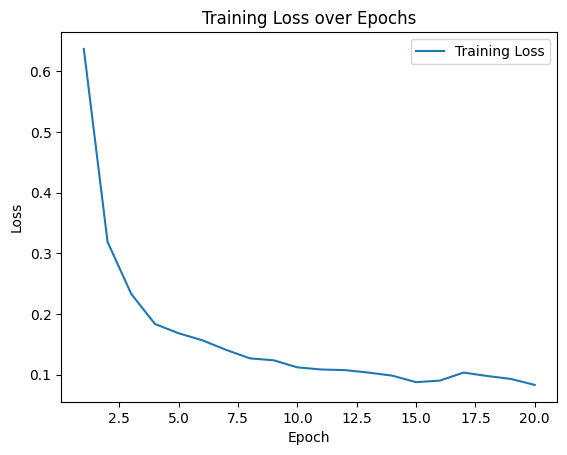

val Loss: 0.0861


In [164]:
# 定义模型
%matplotlib inline   
model = Transformer(input_size = 25, d_model = 64 , num_layers = 2, d_ff = 64 ,num_heads = 4,env_size =20,dropout_rate=0.2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
outcoming =train(model,train_iter,optimizer,20)
valtest =val(model,val_iter)

In [ ]:
# feature_enginner
import time 
start_time = time.time()
alltic_list = [i for i in range(k)]

def Feature_enginner(model, processed_df, full_list, alltic_list, batch_size=64, k=20, env_size=40,dela = 48):
    back_iter = DataLoader(StockDataset_back([i for i in range(k)],full_list), shuffle=False, batch_size=batch_size, num_workers=0,drop_last=False)
    
    new_state = predict(model,back_iter)
    print(1)
    concatenated_tensor = torch.cat(new_state, dim=0)
    print(2)
    concatenated_tensor = concatenated_tensor.view(-1,env_size)
    print(3)
    feature_df = pd.DataFrame(concatenated_tensor.numpy())
    print(4)
    
    full_delay_df = delaydate(dela ,processed_df)
    
    merged_df = pd.concat([full_delay_df, feature_df], axis=1)
    merged_df = merged_df.loc[:,['tic','date','close'] + INDICATORS + [i for i in range(env_size)]]
    merged_df.columns = ['tic','date','close'] + INDICATORS + [f"temporal_feature_{i}" for i in range(env_size)]
    end_time = time.time()
    print('总计消耗时间:',(end_time - start_time)/60)
    return merged_df

In [ ]:
addfeature_df = Feature_enginner(model, processed_df1, array_full_list, alltic_list, batch_size=64, k=50 ,env_size=20, dela=48)

In [ ]:
addfeature_df.columns

In [ ]:
merged_df.columns

In [ ]:
addfeature_df.to_csv('1227_addfeature_df.csv',index=None)

In [ ]:
addfeature_df = pd.read_csv('1227_addfeature_df.csv')

In [ ]:
merged_df = pd.read_csv('1228_merged.csv')

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [ ]:
addfeature_df['date'] = pd.to_datetime(addfeature_df['date'])

In [ ]:
merged_df1 = merged_df[['trade_date','ts_code','filled','ema']]
merged_df1['date'] = pd.to_datetime(merged_df1['trade_date'])
merged_df1['tic'] = merged_df1['ts_code']
merged_df1 = merged_df1.loc[:,('date','tic','filled','ema')]

In [ ]:
addfeature_df1 = pd.merge(addfeature_df,merged_df1,on=('date','tic'),how='left')
addfeature_df1

In [ ]:
processed_df3.to_csv('1227_processed.csv',index=None)

In [ ]:
processed_df3

In [ ]:
processed_df3 = pd.read_csv('1227_processed.csv')

In [ ]:
processed_df3['date'] = pd.to_datetime(processed_df3['date'])

In [ ]:
addfeature_df[addfeature_df['tic'] == '601939.SH']

In [ ]:
torch.triu(g,diagonal=1+3)

In [ ]:
torch.triu(g,diagonal=1)

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [ ]:
TRAIN_START_DATE = '2015-03-02'
TRAIN_END_DATE = '2020-07-30'
TRADE_START_DATE = '2020-07-31'
TRADE_END_DATE = '2021-02-26'

In [ ]:
TRAIN_START_DATE = addfeature_df['date'].unique()[0]

In [ ]:
train = data_split(addfeature_df1, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(addfeature_df1, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

In [ ]:
addfeature_df

In [ ]:
train.tail(10)

In [ ]:
selfattn_indicator_list = [f"temporal_feature_{i}" for i in range(20)]

In [ ]:
selfattn_indicator_list

In [ ]:
trade.head()

In [ ]:
INDICATORS

In [ ]:
# stock_dimension = len(train.tic.unique())
# state_space = 1 + 2*stock_dimension + len(selfattn_indicator_list)*stock_dimension
# print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 4*stock_dimension + len(INDICATORS)*stock_dimension + len(selfattn_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 500,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "risk_preference": 'ne',   #ne为中性、pr为激进,除此之外都是保守策略
    'adjust': True,  #True为启用动态调整机制，False关闭
    "reward_scaling": 1,
    "attn_indicator_list":selfattn_indicator_list,
    "alpha": 100, #风险喜好函数系数
    "beta" : 100, #风险中性函数系数
    "c" : 100, # 风险厌恶函数系数
    "theta" : 0.2, # 风险喜好放缩因子
    "gamma" : 5, # 风险厌恶放缩因子
    "mu" : 1, #惩罚项放缩因子
    "p_lambda" : 100,  #惩罚系数
    'up_ad_thre': 0.15, #动态调整机制中向上变化率阈值
    'down_ad_thre': 0.1,  #动态调整机制中向下变化率阈值
    
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = True
if_using_sac = False


In [ ]:
import torch
device = torch.device("mps")

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=30000) if if_using_ppo else None

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000) if if_using_sac else None

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = addfeature_df[(addfeature_df.date<TRAIN_END_DATE) & (addfeature_df.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

In [ ]:
insample_risk_indicator.turbulence.describe()

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade,**env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

In [ ]:
trained_moedl = trained_td3
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

In [ ]:
df_account_value.to_csv('107_up_up_df_account_value.csv',index=None)

In [ ]:
df_account_value

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

In [ ]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
    baseline['date'] = pd.to_datetime(baseline['date'],format='%Y%m%d')
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
# subset_df = addfeature_df.loc[(addfeature_df['date'].astype(str) >='20210301') & (addfeature_df['date'].astype(str)<='20220227')]
full_date_range1 = pd.DataFrame({'date':df_account_value['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(addfeature_df,full_date_range1,selected_tics)
baseline_sse

In [ ]:
addfeature_df

In [ ]:
baseline_sse.info()

In [ ]:
# baseline_sse = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
# baseline_sse = baseline_sse.rename(columns={'trade_date':'date'})
# baseline_sse = baseline_sse.sort_values('date',ascending=True)
# print(baseline_sse)

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')


In [ ]:
df_account_value

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

In [ ]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print(df_account_value.loc[len(df_account_value)-1,'date'],df_account_value.loc[0,'date'])